# Import

In [1]:
import torch as tc 
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast
import cv2
import os,sys
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
!python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from dotenv import load_dotenv


Looking in links: /kaggle/input/pip-download-for-segmentation-models-pytorch
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/segmentation_models_pytorch-0.3.3-py3-none-any.whl
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/pretrainedmodels-0.7.4.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... - \ done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/efficientnet_pytorch-0.7.1.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... - done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/timm-0.9.2-py3-none-any.whl (from segmentation-models-pytorch)
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/munch-4.0.0-py2.py3-none-any.whl (from pretrainedmodels==0.7.4->segmentation-models-pytorch)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=7a3c20b82c2dceca565200a20

# config

In [2]:
class CFG:
# ============== model CFG =============
    model_name = 'Unet'
    backbone = 'resnext101_32x8d'

    in_chans = 5 # 65
    #============== _ CFG =============
    image_size = 256
    input_size=256
    tile_size = image_size
    stride = tile_size // 2
    drop_egde_pixel=0
    
    target_size = 1
    # ============== fold =============
    valid_id = 1
    batch=128
    th_percentile = 0.0021
    model_path=["/kaggle/input/ver13-resnext101-32x8d-23/ver13_resnext101_32x8d_23_loss0.20_score0.87_val_loss0.14_val_score0.97.pt"]
    #auc=(real auc-0.7)/3*10

# Model

In [3]:
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.CFG = CFG
        self.encoder = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )
        self.batch=CFG.batch

    def forward_(self, image):
        output = self.encoder(image)
        return output[:,0]
    
    def forward(self,x:tc.Tensor):
        x=x.to(tc.float32)
        x=normalization(x,1)
        #x.shape=(batch,c,h,w)
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x,size=(CFG.input_size,CFG.input_size),mode='bilinear',align_corners=True)
        
        shape=x.shape
        x=[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(4)]
        x=tc.cat(x,dim=0)
        with autocast():
            with tc.no_grad():
                x=[self.forward_(x[i*self.batch:(i+1)*self.batch]) for i in range(x.shape[0]//self.batch+1)]
                # batch=64,64...48
                x=tc.cat(x,dim=0)
        x=x.sigmoid()
        x=x.reshape(4,shape[0],*shape[2:])
        x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
        x=tc.stack(x,dim=0).mean(0)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x[None],size=(CFG.image_size,CFG.image_size),mode='bilinear',align_corners=True)[0]
        return x


def build_model(weight=None):
    load_dotenv()

    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model.cuda()

# Functions

In [4]:
def rle_encode(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 1'
    return rle

def normalization(x:tc.Tensor,smooth=1e-7)->tc.Tensor:
    """input.shape=(batch,f1,f2,...)"""
    #[batch,f1,f2]->dim[1,2]
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    return (x-mean)/(std+smooth)


class Data_loader(Dataset):
    def __init__(self,path,s="/images/"):
        self.paths=glob(path+f"{s}*.tif")
        self.paths.sort()
        self.bool=s=="/labels/"
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img=cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        img=tc.from_numpy(img)
        if self.bool:
            img=img.to(tc.bool)
        else:
            img=img.to(tc.uint8)
        return img

def load_data(path,s):
    data_loader=Data_loader(path,s)
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=2)
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=tc.cat(data,dim=0)
    return x

class Pipeline_Dataset(Dataset):
    def __init__(self,x,path):
        self.img_paths  = glob(path+"/images/*")
        self.img_paths.sort()
        #assert int(self.img_paths[-1].split("/")[-1][:-4])+1==len(x)#it seem not same
        self.in_chan = CFG.in_chans
        z=tc.zeros(self.in_chan//2,*x.shape[1:],dtype=x.dtype)
        self.x=tc.cat((z,x,z),dim=0)
        
    def __len__(self):
        return self.x.shape[0]-self.in_chan+1
    
    def __getitem__(self, index):
        x  = self.x[index:index+self.in_chan]
        return x,index
    
    def get_mark(self,index):
        id=self.img_paths[index].split("/")[-3:]
        id.pop(1)
        id="_".join(id)
        return id[:-4]
    
    def get_marks(self):
        ids=[]
        for index in range(len(self)):
            ids.append(self.get_mark(index))
        return ids

def add_edge(x:tc.Tensor,edge:int):
    #x=(C,H,W)
    #output=(C,H+2*edge,W+2*edge)
    mean_=int(x.to(tc.float32).mean())
    x=tc.cat([x,tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_],dim=1)
    x=tc.cat([x,tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_],dim=2)
    x=tc.cat([tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_,x],dim=1)
    x=tc.cat([tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_,x],dim=2)
    return x

# Build model(s)

In [5]:
model=build_model()
model.load_state_dict(tc.load(CFG.model_path[0],"cpu"))
model=DataParallel(model)

model_name Unet
backbone resnext101_32x8d


In [6]:
def get_output(debug=False):
    outputs=[]
    if debug:
        paths=["/kaggle/input/blood-vessel-segmentation/train/kidney_2"]
    else:
        paths=glob("/kaggle/input/blood-vessel-segmentation/test/*")
    outputs=[[],[]]
    for path in paths:
        x=load_data(path,"/images/")
        labels=tc.zeros_like(x,dtype=tc.uint8)
        mark=Pipeline_Dataset(x,path).get_marks()
        for axis in [0,1,2]:
            debug_count=0
            if axis==0:
                x_=x
                labels_=labels
            elif axis==1:
                x_=x.permute(1,2,0)
                labels_=labels.permute(1,2,0)
            elif axis==2:
                x_=x.permute(2,0,1)
                labels_=labels.permute(2,0,1)
            if x.shape[0]==3 and axis!=0:
                break
            dataset=Pipeline_Dataset(x_,path)
            dataloader=DataLoader(dataset,batch_size=1,shuffle=False,num_workers=2)
            shape=dataset.x.shape[-2:]
            x1_list = np.arange(0, shape[0]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
            y1_list = np.arange(0, shape[1]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
            for img,index in tqdm(dataloader):
                #img=(1,C,H,W)
                img=img.to("cuda:0")
                img=add_edge(img[0],CFG.tile_size//2)[None]

                mask_pred = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)
                mask_count = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)

                indexs=[]
                chip=[]
                for y1 in y1_list:
                    for x1 in x1_list:
                        x2 = x1 + CFG.tile_size
                        y2 = y1 + CFG.tile_size
                        indexs.append([x1+CFG.drop_egde_pixel,x2-CFG.drop_egde_pixel,
                                       y1+CFG.drop_egde_pixel,y2-CFG.drop_egde_pixel])
                        chip.append(img[...,x1:x2,y1:y2])

                y_preds = model.forward(tc.cat(chip)).to(device=0)

                if CFG.drop_egde_pixel:
                    y_preds=y_preds[...,CFG.drop_egde_pixel:-CFG.drop_egde_pixel,
                                        CFG.drop_egde_pixel:-CFG.drop_egde_pixel]
                for i,(x1,x2,y1,y2) in enumerate(indexs):
                    mask_pred[...,x1:x2, y1:y2] += y_preds[i]
                    mask_count[...,x1:x2, y1:y2] += 1

                mask_pred /= mask_count

                #Rrecover
                mask_pred=mask_pred[...,CFG.tile_size//2:-CFG.tile_size//2,CFG.tile_size//2:-CFG.tile_size//2]
                
                labels_[index]+=(mask_pred[0]*255/3).to(tc.uint8).cpu()
                if debug:
                    debug_count+=1
                    plt.subplot(121)
                    plt.imshow(img[0,CFG.in_chans//2].cpu().detach().numpy())
                    plt.subplot(122)
                    plt.imshow(mask_pred[0].cpu().detach().numpy())
                    plt.show()
                    if debug_count>3:
                        break
        outputs[0].append(labels)
        outputs[1].extend(mark)
    return outputs

  0%|          | 0/2217 [00:00<?, ?it/s]

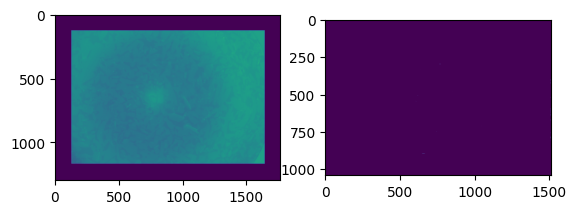

  0%|          | 1/2217 [00:10<6:44:53, 10.96s/it]

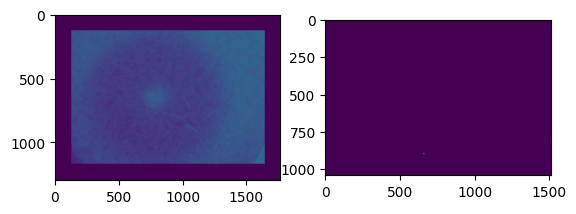

  0%|          | 2/2217 [00:12<3:27:52,  5.63s/it]

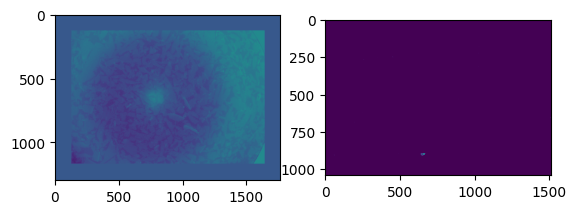

  0%|          | 3/2217 [00:14<2:25:14,  3.94s/it]

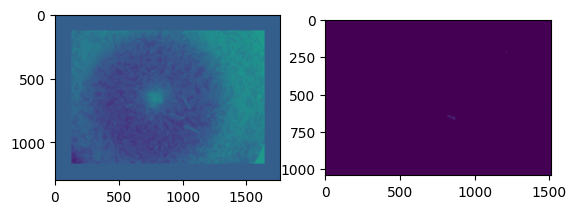

  0%|          | 0/1041 [00:00<?, ?it/s]

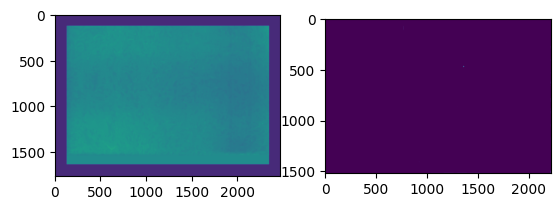

  0%|          | 1/1041 [00:03<1:07:32,  3.90s/it]

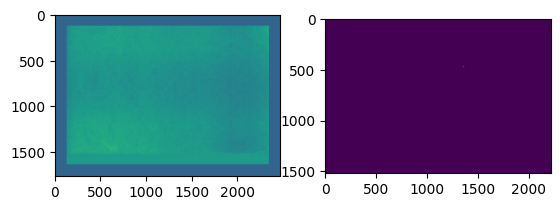

  0%|          | 2/1041 [00:07<1:04:12,  3.71s/it]

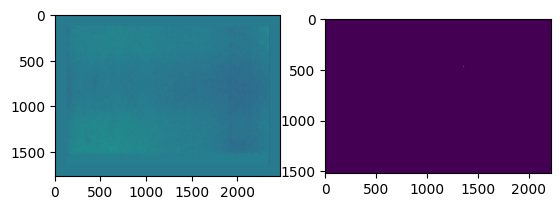

  0%|          | 3/1041 [00:11<1:03:00,  3.64s/it]

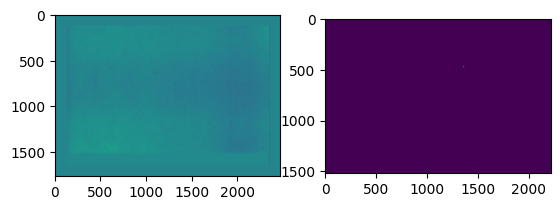

  0%|          | 0/1511 [00:00<?, ?it/s]

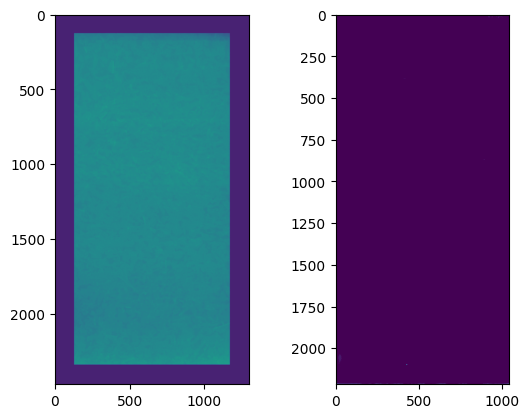

  0%|          | 1/1511 [00:06<2:48:11,  6.68s/it]

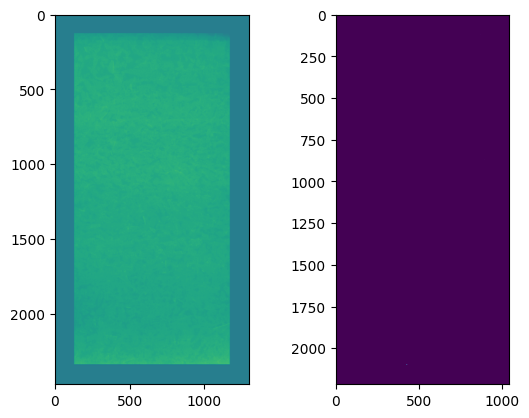

  0%|          | 2/1511 [00:09<1:51:46,  4.44s/it]

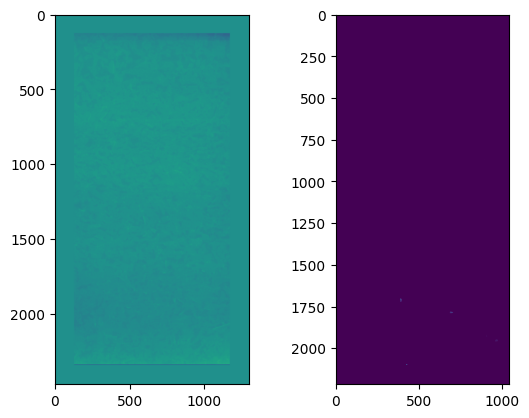

  0%|          | 3/1511 [00:12<1:32:02,  3.66s/it]

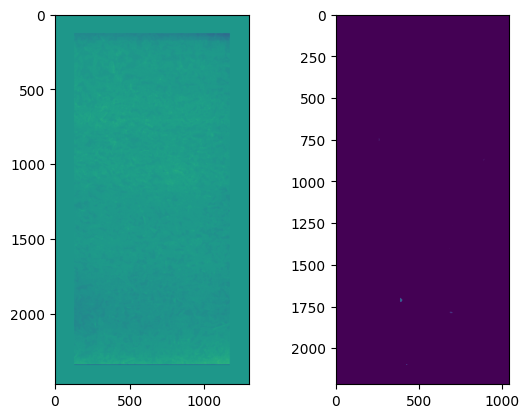

  0%|          | 3/1511 [00:15<2:09:02,  5.13s/it]


0


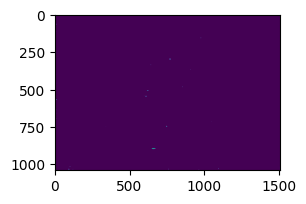

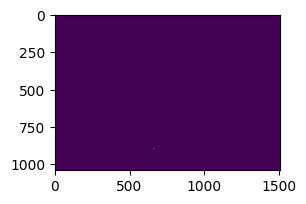

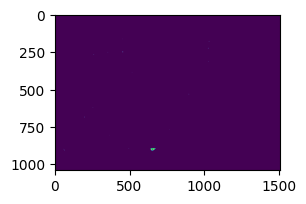

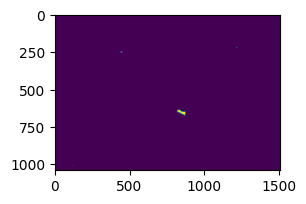

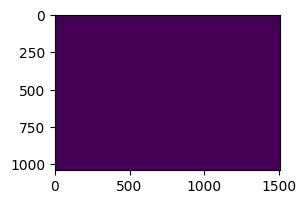

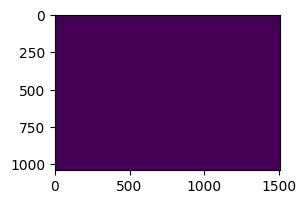

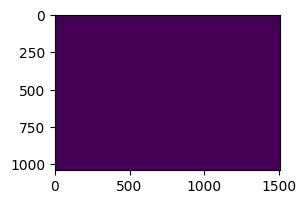

,id,rle
0,kidney_2_0000,3414 2 11165 1 12295 1 12320 1 12676 1 13830 1...
0,kidney_2_0001,3559 3 3778 2 3904 1 3915 2 5410 2 445749 1 44...
0,kidney_2_0002,3778 2 3903 2 3914 4 5290 1 5409 3 120881 1 12...
0,kidney_2_0003,3779 1 3904 1 3914 4 4170 3 5409 2 335146 2 33...
0,kidney_2_0004,1536689 1 1538200 1 1539711 1 1541222 1 154273...
0,kidney_2_0005,1541222 1 1542733 1 1544244 1 1545755 1 1547266 1


In [7]:
is_submit=len(glob("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/*.tif"))!=3
#is_submit=True
output,ids=get_output(not is_submit)


####################################
TH=[x.flatten().numpy() for x in output]
TH=np.concatenate(TH)
index = -int(len(TH) * CFG.th_percentile)
TH:int = np.partition(TH, index)[index]
print(TH)

####################################
submission_df=[]
debug_count=0
for index in range(len(ids)):
    id=ids[index]
    i=0
    for x in output:
        if index>=len(x):
            index-=len(x)
            i+=1
        else:
            break
    mask_pred=(output[i][index]>TH).numpy()
    ####################################
    if not is_submit:
        plt.subplot(121)
        plt.imshow(mask_pred)
        plt.show()
        debug_count+=1
        if debug_count>6:
            break
        
    rle = rle_encode(mask_pred)
    
    submission_df.append(
        pd.DataFrame(data={
            'id'  : id,
            'rle' : rle,
        },index=[0])
    )

submission_df =pd.concat(submission_df)
submission_df.to_csv('submission.csv', index=False)
submission_df.head(6)